<a href="https://colab.research.google.com/github/RavichandranPrabhakaran/html-practice/blob/main/Medical_prescription_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mamun1113_doctors_handwritten_prescription_bd_dataset_path = kagglehub.dataset_download('mamun1113/doctors-handwritten-prescription-bd-dataset')

print('Data source import complete.')


Data source import complete.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
class HandwrittenDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None, max_label_length=11):
        self.image_dir = image_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        self.max_label_length = max_label_length

        unique_chars = set(''.join(self.data['MEDICINE_NAME']))
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(unique_chars))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            img_name = self.data.iloc[idx, 0]
            label = self.data.iloc[idx, 1]
            image_path = os.path.join(self.image_dir, img_name)
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            encoded_label = self.encode_label(label)
            return image, encoded_label
        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            return None

    def encode_label(self, label):
        label = label[:self.max_label_length].ljust(self.max_label_length)
        return torch.tensor([self.char_to_idx.get(char, 0) for char in label])

In [4]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])

    batch.sort(key=lambda x: len(x[1]), reverse=True)
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    labels = torch.nn.utils.rnn.pad_sequence([l for l in labels], batch_first=True, padding_value=0)
    return images, labels

In [5]:
class OCRModel(nn.Module):
    def __init__(self, num_classes, max_length=11):
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes * max_length)
        self.max_length = max_length
        self.num_classes = num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, self.max_length, self.num_classes)


In [6]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


In [18]:
train_image_dir = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Training', 'training_words')
train_csv_file = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Training', 'training_labels.csv')

test_image_dir = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Testing', 'testing_words')
test_csv_file = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Testing', 'testing_labels.csv')

validation_image_dir = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Validation', 'validation_words')
validation_csv_file = os.path.join(mamun1113_doctors_handwritten_prescription_bd_dataset_path, 'Doctor’s Handwritten Prescription BD dataset', 'Validation', 'validation_labels.csv')

In [19]:
# Create datasets
train_dataset = HandwrittenDataset(image_dir=train_image_dir, csv_file=train_csv_file, transform=transform)
test_dataset = HandwrittenDataset(image_dir=test_image_dir, csv_file=test_csv_file, transform=transform)
validation_dataset = HandwrittenDataset(image_dir=validation_image_dir, csv_file=validation_csv_file, transform=transform)


In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [21]:
num_classes = train_dataset.num_classes
max_length = 11  # Assuming max_label_length is 11
model = OCRModel(num_classes, max_length)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [22]:

# Training loop
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.reshape(-1, num_classes), labels.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 2)
            total += labels.numel()
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/50], Loss: 2.6886
Validation Accuracy: 9.79%
Epoch [2/50], Loss: 2.6025
Validation Accuracy: 11.11%
Epoch [3/50], Loss: 2.5322
Validation Accuracy: 11.71%
Epoch [4/50], Loss: 2.3620
Validation Accuracy: 16.71%
Epoch [5/50], Loss: 2.0199
Validation Accuracy: 22.39%
Epoch [6/50], Loss: 1.6070
Validation Accuracy: 29.80%
Epoch [7/50], Loss: 1.2042
Validation Accuracy: 33.09%
Epoch [8/50], Loss: 0.8936
Validation Accuracy: 36.28%
Epoch [9/50], Loss: 0.6522
Validation Accuracy: 37.93%
Epoch [10/50], Loss: 0.4543
Validation Accuracy: 39.63%
Epoch [11/50], Loss: 0.3105
Validation Accuracy: 40.14%
Epoch [12/50], Loss: 0.1951
Validation Accuracy: 41.18%
Epoch [13/50], Loss: 0.1207
Validation Accuracy: 41.35%
Epoch [14/50], Loss: 0.0690
Validation Accuracy: 41.07%
Epoch [15/50], Loss: 0.0320
Validation Accuracy: 42.04%
Epoch [16/50], Loss: 0.0156
Validation Accuracy: 42.20%
Epoch [17/50], Loss: 0.0066
Validation Accuracy: 42.32%
Epoch [18/50], Loss: 0.0034
Validation Accuracy: 42.49%
Ep

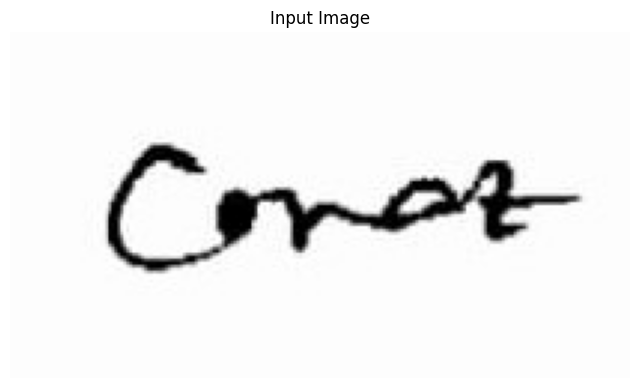

Predicted word: Conazxneind


In [23]:
def predict_from_image(model, image_path, idx_to_char, device):
    model.eval()
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')


    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Forward pass
    with torch.no_grad():
        output = model(image_tensor)

    # Get predicted indices
    _, predicted_indices = torch.max(output, 2)
    predicted_indices = predicted_indices.squeeze().cpu().numpy()

    # Convert indices to characters
    predicted_chars = [idx_to_char[idx] for idx in predicted_indices]

    # Join characters to form the predicted word
    predicted_word = ''.join(predicted_chars).strip()

    return predicted_word


image_path ='/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/190.png'
idx_to_char = {v: k for k, v in train_dataset.char_to_idx.items()}  # Reverse the char_to_idx mapping

predicted_word = predict_from_image(model, image_path, idx_to_char, device)
print("Predicted word:", predicted_word)

In [17]:
import os

# The path returned by kagglehub.dataset_download
download_path = mamun1113_doctors_handwritten_prescription_bd_dataset_path

# List the contents of the downloaded directory
for root, dirs, files in os.walk(download_path):
    print(root)
    for d in dirs:
        print(os.path.join(root, d))
    for f in files:
        print(os.path.join(root, f))

/kaggle/input/doctors-handwritten-prescription-bd-dataset
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv
/kaggle/input/doct

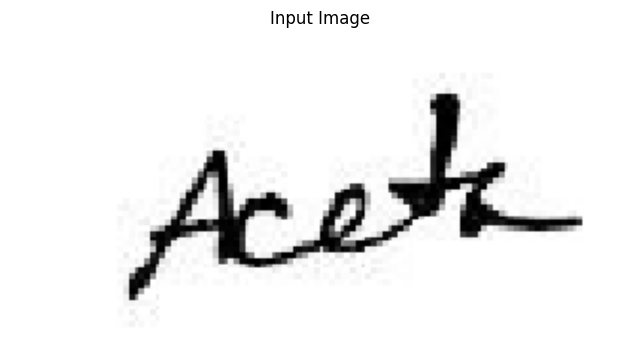

Actual label: Aceta, Predicted word: Cintaofeend


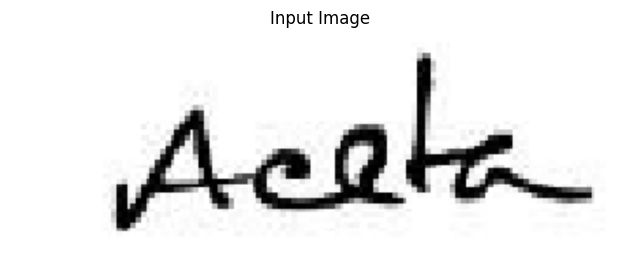

Actual label: Aceta, Predicted word: Cantaoleind


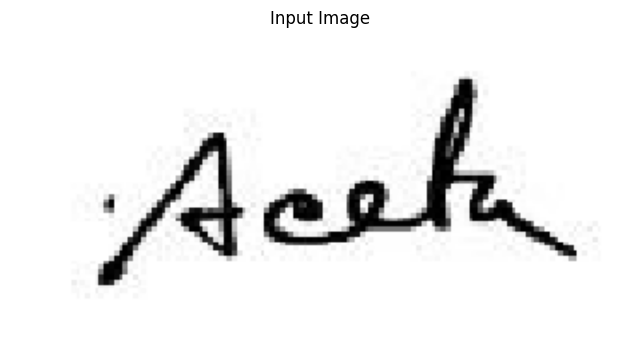

Actual label: Aceta, Predicted word: Canaaoleend


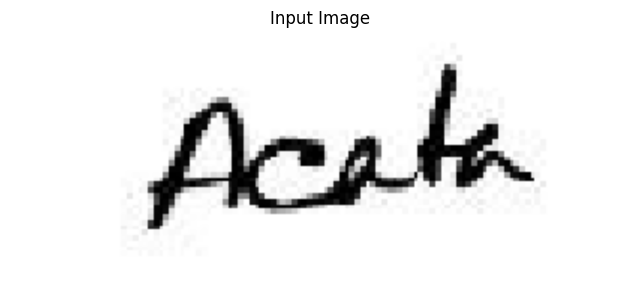

Actual label: Aceta, Predicted word: Fixaatieind


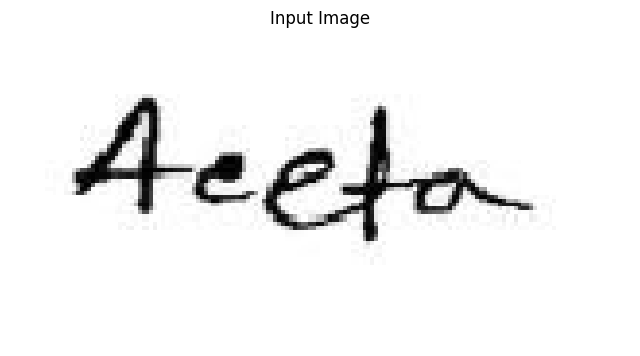

Actual label: Aceta, Predicted word: Axodinnxind


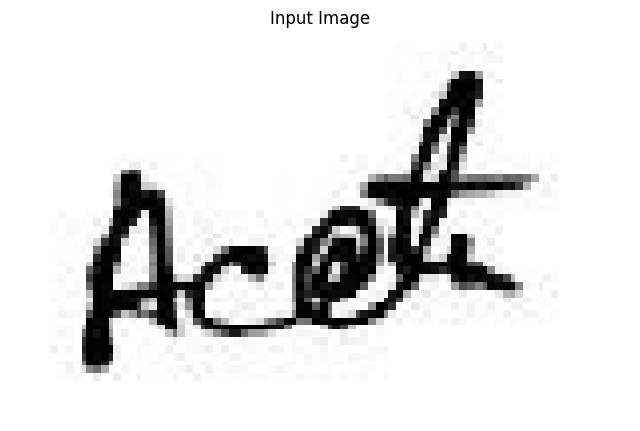

Actual label: Aceta, Predicted word: Aaottoleind


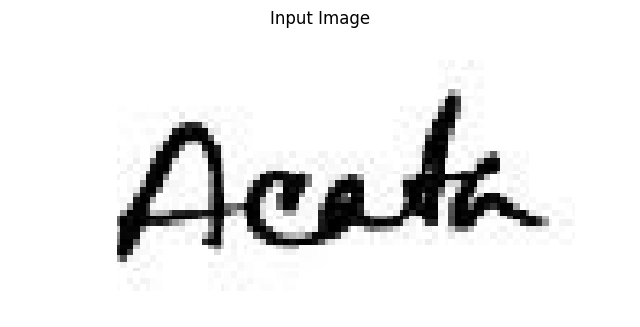

Actual label: Aceta, Predicted word: Aietalieind


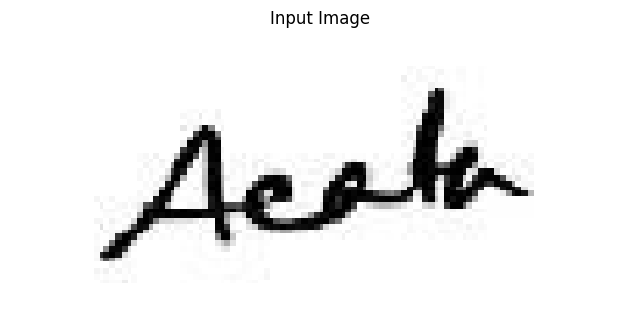

Actual label: Aceta, Predicted word: Aiotaoleend


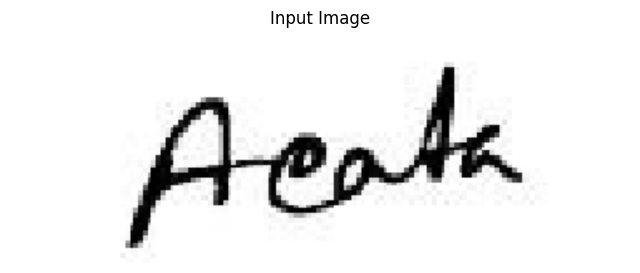

Actual label: Aceta, Predicted word: Aixtalilind


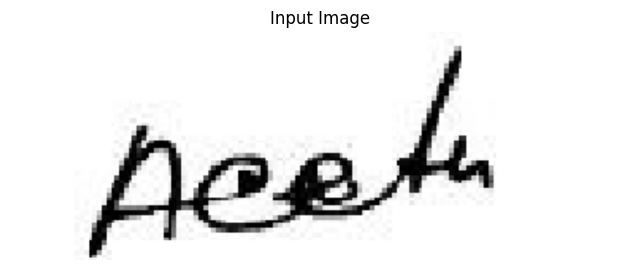

Actual label: Aceta, Predicted word: Bicaidleind


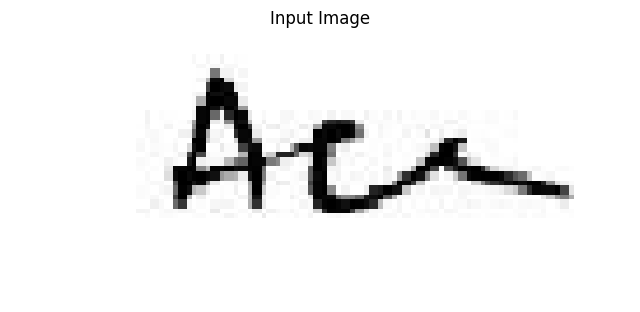

Actual label: Ace, Predicted word: Netaanreind


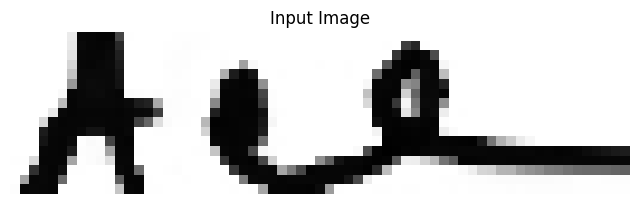

Actual label: Ace, Predicted word: Acetotnlind


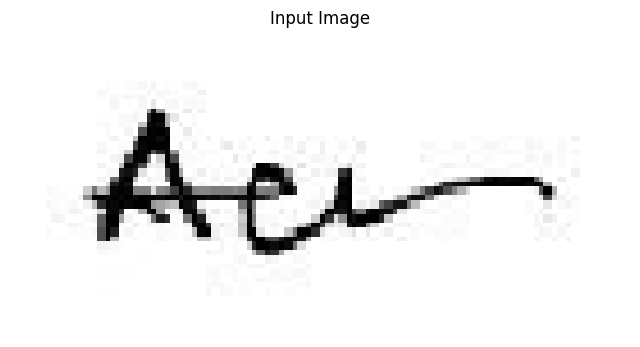

Actual label: Ace, Predicted word: Axouinneind


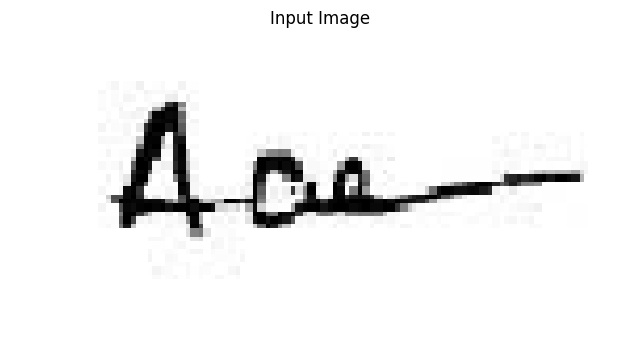

Actual label: Ace, Predicted word: Extumnnxind


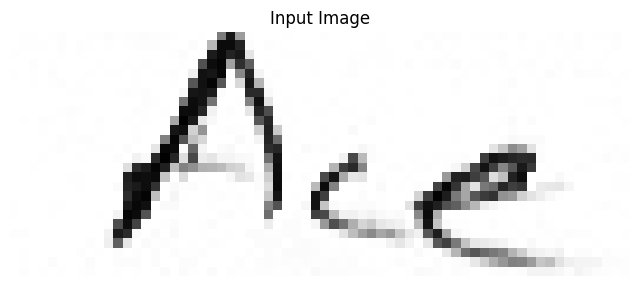

Actual label: Ace, Predicted word: Fzxumlncind


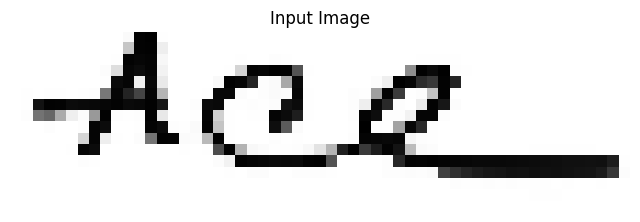

Actual label: Ace, Predicted word: Tiodosilind


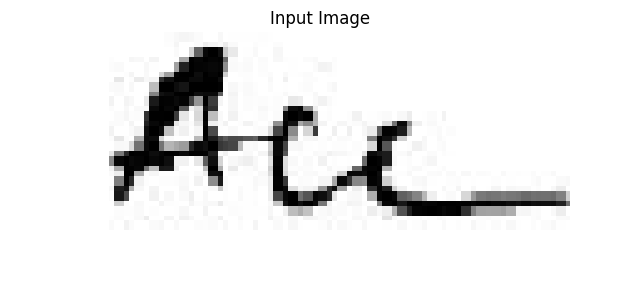

Actual label: Ace, Predicted word: Acethlixind


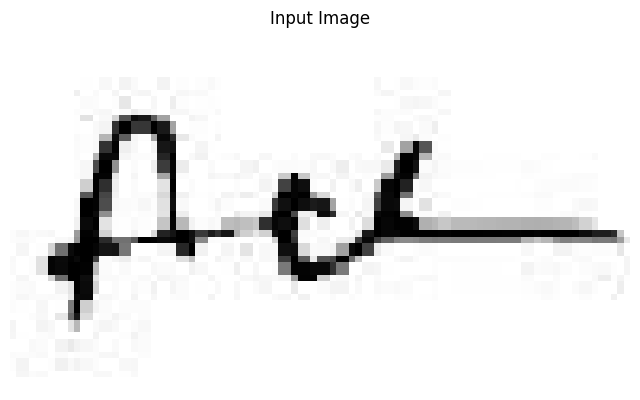

Actual label: Ace, Predicted word: Riaozinlind


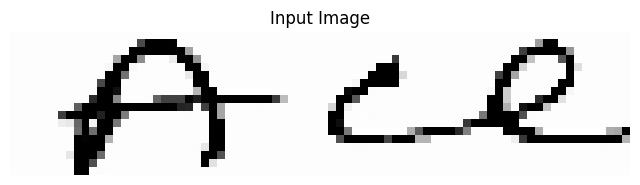

Actual label: Ace, Predicted word: Rexialrtind


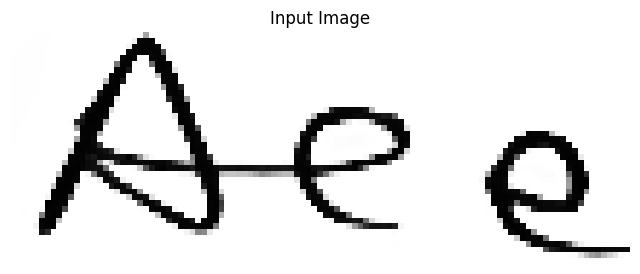

Actual label: Ace, Predicted word: Nexizircind


In [25]:
# Get a few samples from the test dataset
num_samples_to_check = 20
test_samples = []
for i in range(num_samples_to_check):
    # Get the image path and actual label from the test dataset
    img_name = test_dataset.data.iloc[i, 0]
    actual_label = test_dataset.data.iloc[i, 1]
    image_path = os.path.join(test_image_dir, img_name)
    test_samples.append((image_path, actual_label))

# Predict and display for each sample
for image_path, actual_label in test_samples:
    predicted_word = predict_from_image(model, image_path, idx_to_char, device)
    print(f"Actual label: {actual_label}, Predicted word: {predicted_word}")